<a href="https://colab.research.google.com/github/scaber/SongClassification/blob/main/Gurultu_giderildi_LR_10_uzeri_4ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_cv
!pip install -U tensorflow
!pip install -U soundfile
!pip install -U pip setuptools wheel
!pip install -U numpy pandas
#!pip install jax==0.4.26 jaxlib==0.4.26 # Try a slightly older JAX compatible with older numpy/ml_dtypes
!pip install ml_dtypes==0.3.2 # Force the ml_dtypes version TF 2.17 needs


!pip install -U tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.9 MB/s  0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
  Using cached ml_dtypes-0.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Attempting uninstall: ml_dtypes
    Found existi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch"

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
# import tensorflow_io as tfio
import soundfile as sf

import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl
cmap =plt.get_cmap('coolwarm')


**Her çalıştırmada benzer sonuçlar üretmek için rastgelelik tohumunun (random seed) değerini ayarlar.**





In [ ]:
class CFG:
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 2048
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, model name
    epochs = 100
    preset = 'efficientnetv2_b2_imagenet'
    presetdensenet121_imagenet='densenet121_imagenet'
    resnet_50_imagenet='resnet50_imagenet'
    vgg16='bert_base_en'
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('/content/drive/My Drive/extracted_data/train_audio_denoisedtorch'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [ ]:
tf.keras.utils.set_random_seed(CFG.seed)

In [ ]:
BASE_PATH = '/content/drive/My Drive/extracted_data'

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio_denoisedtorch/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(2)

primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   

      scientific_name             common_name            author  \
0  Muscicapa dauurica  Asian Brown Flycatcher    Matt Slaymaker   
1  Muscicapa dauurica  Asian Brown Flycatcher  Magnus Hellström   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   

                                 url      filename  \
0  https://www.xeno-canto.org/134896  XC134896.ogg   
1  https://www.xeno-canto.org/164848  XC164848.ogg   

                                            filepath  target     xc_id  
0  /content/drive/My Drive/extracted_data/train_a...       0  XC134896  
1  /content/drive/My Drive/extracted_data/train_a...       0  XC164848

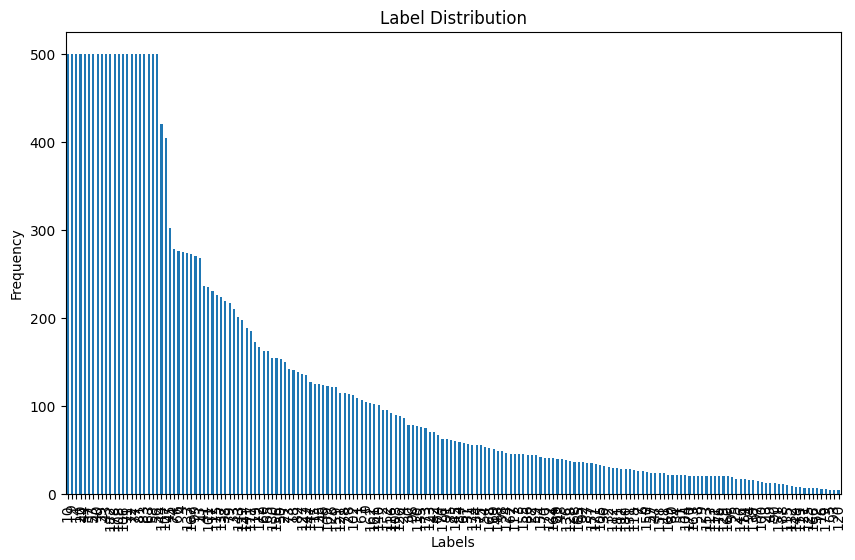

In [ ]:

label_counts = df['target'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()


## Utility

# Data Loader 🍚

In [ ]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec
def get_spectrogramchroma_stft(audio):
    spec = librosa.feature.mfcc(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

# Audio:


# Visualization:


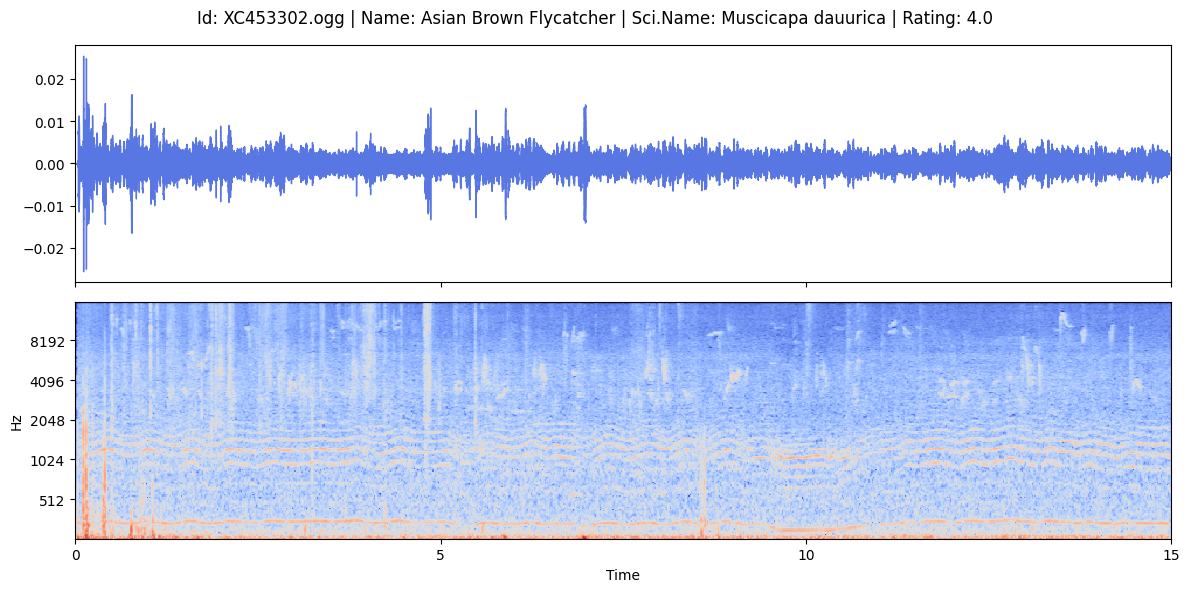

In [ ]:
row = df.iloc[32]

# Display audio
display_audio(row)

## Decoders

 Aşağıdaki kod, `.ogg` dosyasından ham sesi çözecek ve ses dosyasından spektrogramı çıkaracaktır. Ek olarak, modele tutarlı girdiler sağlamak için Z-Skor standardizasyonu ve Min-Max normalizasyonu uygulanacaktır.

In [ ]:
# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
    # def get_audio(filepath):
    #     file_bytes = tf.io.read_file(filepath)
    #     audio = tfio.audio.decode_vorbis(file_bytes)  # decode .ogg file
    #     audio = tf.cast(audio, tf.float32)
    #     if tf.shape(audio)[1] > 1:  # stereo -> mono
    #         audio = audio[..., 0:1]
    #     audio = tf.squeeze(audio, axis=-1)
    #     return audio

    def load_audio_ogg(filepath):
      def _load(path):
          path = path.decode()
          audio, sr = sf.read(path)
          if len(audio.shape) > 1:
              audio = np.mean(audio, axis=1)  # stereo -> mono
          return audio.astype(np.float32)
      audio = tf.numpy_function(_load, [filepath], tf.float32)
      return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = load_audio_ogg(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio)
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode


## Augmenters
Aşağıdaki kod, spektrogram verilerine augmentasyon (veri artırma) uygulayacaktır. Bu not defterinde, KerasCV'den MixUp, CutOut (TimeMasking ve FreqMasking) yöntemlerini kullanacağız.

>  Not: Bu augmentasyonlar, tek bir spektrogram yerine spektrogramlardan oluşan bir topluluğa (batch) uygulanacaktır.

In [ ]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]

    return augment

##  Veri Akışı
Aşağıdaki kod, veri akışının tam bir veri işleme hattını oluşturur. Veri işleme için tf.data.Dataset kullanır. İşte tf.data'nın bazı harika özellikleri:

tf.data API'si ile basit ve tekrar kullanılabilir parçalar kullanarak karmaşık giriş hatları oluşturabiliriz.
* Örneğin, bir ses modeli için veri hattı, dağıtılmış bir dosya sistemindeki dosyalardan verileri toplayabilir, her bir ses/spektrogram üzerinde rastgele dönüşüm/augmentasyon uygulayabilir ve rastgele seçilmiş verileri bir toplu eğitim (batch) için birleştirebilir.
* Ayrıca tf.data API, bir veya daha fazla parça içeren bileşenlerin bir sırasını temsil eden bir tf.data.Dataset özelliği sağlar. Örneğin, bir ses hattında bir bileşen, ses ve etiketi temsil eden bir çift tensör parçasıyla tek bir eğitim örneği olabilir.


## **EfficientNetV2Backbone**

In [ ]:
from tensorflow.keras.optimizers import Adam
# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))
# Pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    CFG.preset,
)
out = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=CFG.num_classes,
    name="classifier"
)(inp)
# Build model
model = keras.models.Model(inputs=inp, outputs=out)
# Compile model with optimizer, loss and metrics
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.AUC(name='auc')],
             )
model.summary()
modelName="EfficientNetV2Backbone"

100%|██████████| 1.79k/1.79k [00:00<00:00, 3.61MB/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (ImageClassifier)    │ (None, 183)            │     9,027,221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,027,221 (34.44 MB)

 Trainable params: 8,944,933 (34.12 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [ ]:

def build_dataset(paths, labels=None, batch_size=32,
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048, repeat=True):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

# LR Schedule ⚓
* Learning Rate scheduler for transfer learning.
* The learning rate starts from `lr_start`, then decreases to a`lr_min` using different methods namely,
    * **step**: Reduce lr step wise like stair.
    * **cos**: Follow Cosine graph to reduce lr.
    * **exp**: Reduce lr exponentially.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=100, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

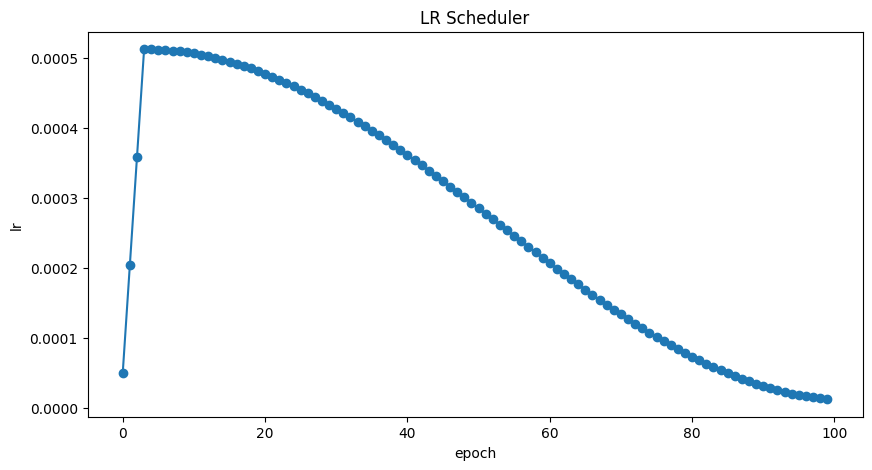

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# Model Checkpoint 💾

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# EarlyStopping callback'ini oluştur
early_stopping = EarlyStopping(
    monitor='val_auc',          # Takip edilecek metrik. ModelCheckpoint ile aynı olması tutarlılık sağlar.
    patience=10,                # Metrikte iyileşme olmadan beklenecek epoch sayısı. 10 iyi bir başlangıç noktasıdır.
    verbose=1,                  # Durdurma gerçekleştiğinde ekrana bilgi yazdırır.
    mode='max',                 # Takip edilen metrik 'auc' olduğu için onu maksimize etmeye çalışıyoruz ('max'). Eğer 'val_loss' olsaydı 'min' olurdu.
    restore_best_weights=True   # Bu çok önemli! Eğitim durduğunda, modelin ağırlıklarını takip edilen metriğin en iyi olduğu anki haline geri yükler.
)

# Training 🚄 KFOLD

In [ ]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import numpy as np
import os
import json,codecs
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

import os
from datetime import datetime

from tensorflow.keras.callbacks import EarlyStopping

# Zaman damgası oluştur (örnek: 2025-10-14_21-34-12)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))
!nvidia-smi



TensorFlow version: 2.20.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mon Nov 10 05:36:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             26W /   70W |     166MiB /  15360MiB |      0%      Default |
|                                

##################################################
Fold 1/5 BAŞLIYOR
Bu katmandaki EĞİTİM verisi sayısı: 19567
Bu katmandaki DOĞRULAMA verisi sayısı: 4892
##################################################
Fold 1/5
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 267s 528ms/step - auc: 0.7208 - loss: 4.8055 - val_auc: 0.6169 - val_loss: 5.1890
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 311ms/step - auc: 0.7911 - loss: 4.2783 - val_auc: 0.7123 - val_loss: 4.7258
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8405 - loss: 3.6625 - val_auc: 0.7805 - val_loss: 4.2739
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8583 - loss: 3.1965 - val_auc: 0.8357 - val_loss: 3.8347
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8756 - loss: 2.7549 - val_auc: 0.8663 - val_loss: 3.5148
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8810 - loss: 2.4596 - val_auc: 0.8783 - val_loss: 3.3257
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 311ms/s

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Fold 1 raporu kaydedildi: /content/drive/My Drive/extracted_data/10KasimLR10uzeri4Noised/classification_report_fold_1.csv
✅ Fold 1 Accuracy: 0.5857


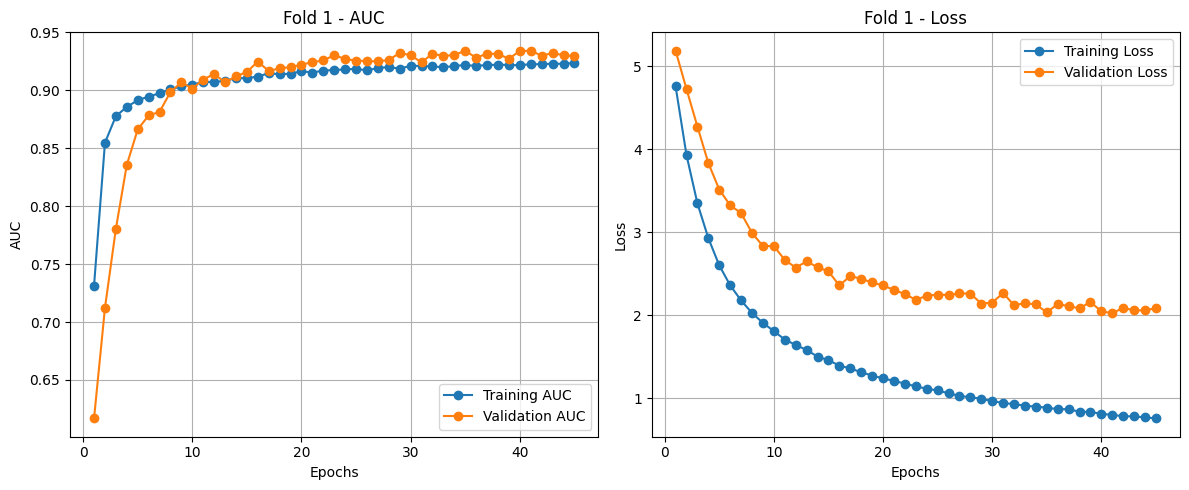

##################################################
Fold 2/5 BAŞLIYOR
Bu katmandaki EĞİTİM verisi sayısı: 19567
Bu katmandaki DOĞRULAMA verisi sayısı: 4892
##################################################
Fold 2/5
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 265s 526ms/step - auc: 0.7258 - loss: 4.7860 - val_auc: 0.6002 - val_loss: 5.2086
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 311ms/step - auc: 0.7984 - loss: 4.2420 - val_auc: 0.7062 - val_loss: 4.7082
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 94s 309ms/step - auc: 0.8354 - loss: 3.7326 - val_auc: 0.7972 - val_loss: 4.1616
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 94s 309ms/step - auc: 0.8561 - loss: 3.2317 - val_auc: 0.8440 - val_loss: 3.7662
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8716 - loss: 2.8095 - val_auc: 0.8640 - val_loss: 3.5049
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 94s 309ms/step - auc: 0.8800 - loss: 2.5108 - val_auc: 0.8834 - val_loss: 3.2639
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/s

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Fold 2 raporu kaydedildi: /content/drive/My Drive/extracted_data/10KasimLR10uzeri4Noised/classification_report_fold_2.csv
✅ Fold 2 Accuracy: 0.6254


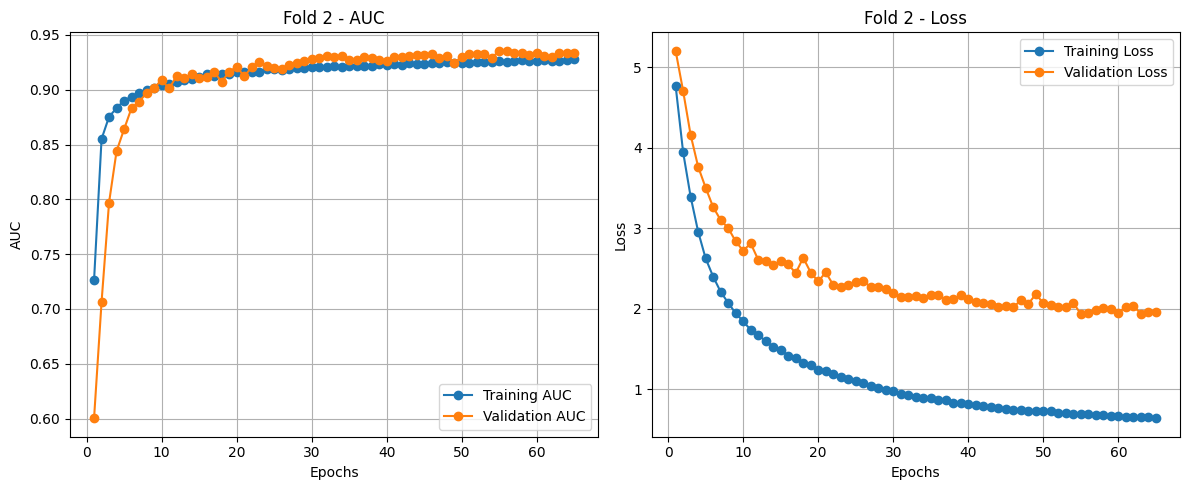

##################################################
Fold 3/5 BAŞLIYOR
Bu katmandaki EĞİTİM verisi sayısı: 19567
Bu katmandaki DOĞRULAMA verisi sayısı: 4892
##################################################
Fold 3/5
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 269s 529ms/step - auc: 0.7333 - loss: 4.7781 - val_auc: 0.6428 - val_loss: 5.0322
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 312ms/step - auc: 0.7871 - loss: 4.2768 - val_auc: 0.7323 - val_loss: 4.5895
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8353 - loss: 3.6800 - val_auc: 0.7991 - val_loss: 4.1462
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8596 - loss: 3.1717 - val_auc: 0.8356 - val_loss: 3.8043
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8724 - loss: 2.7646 - val_auc: 0.8693 - val_loss: 3.4400
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8843 - loss: 2.4356 - val_auc: 0.8760 - val_loss: 3.3312
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 311ms/s

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Fold 3 raporu kaydedildi: /content/drive/My Drive/extracted_data/10KasimLR10uzeri4Noised/classification_report_fold_3.csv
✅ Fold 3 Accuracy: 0.6178


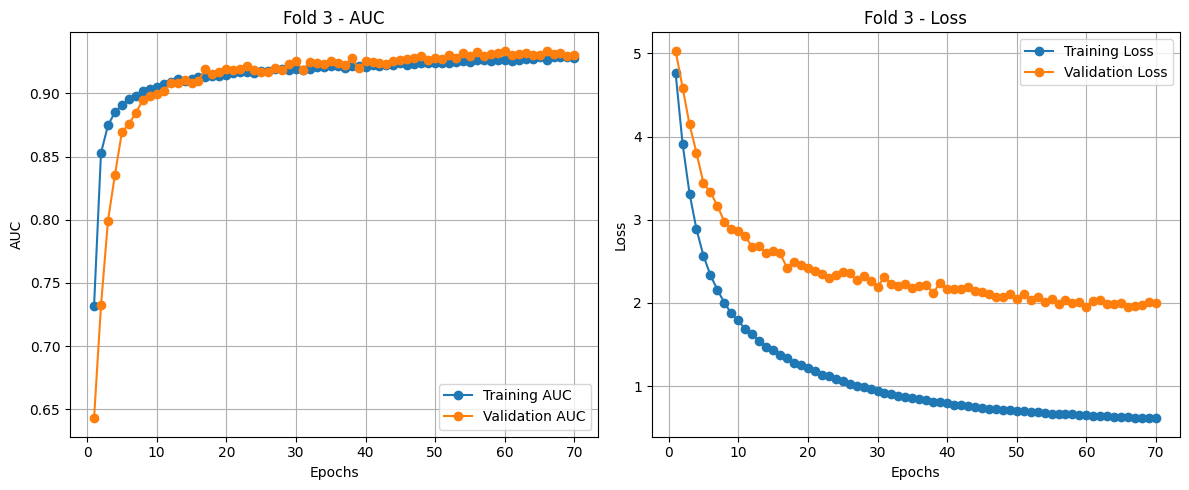

##################################################
Fold 4/5 BAŞLIYOR
Bu katmandaki EĞİTİM verisi sayısı: 19567
Bu katmandaki DOĞRULAMA verisi sayısı: 4892
##################################################
Fold 4/5
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 271s 527ms/step - auc: 0.7083 - loss: 4.8349 - val_auc: 0.5936 - val_loss: 5.2426
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 312ms/step - auc: 0.7867 - loss: 4.2976 - val_auc: 0.6988 - val_loss: 4.7591
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8313 - loss: 3.7859 - val_auc: 0.7794 - val_loss: 4.2871
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 311ms/step - auc: 0.8572 - loss: 3.2729 - val_auc: 0.8414 - val_loss: 3.8114
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 311ms/step - auc: 0.8769 - loss: 2.8008 - val_auc: 0.8677 - val_loss: 3.5065
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 310ms/step - auc: 0.8855 - loss: 2.4778 - val_auc: 0.8776 - val_loss: 3.3323
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 311ms/s

In [ ]:
# Verileri ve etiketleri hazırlayın
X = df['filepath'].values  # Dosya yolları (özellikler olarak kullanılacak)
y = df['target'].values    # Sınıf etiketleri

# StratifiedKFold ayarı
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Performans sonuçlarını saklamak için liste
fold_accuracies = []
fold_reports = []
fold_f1s = []

# Model ve geçmişi kaydetmek için dizin
model_save_dir = BASE_PATH+"/10KasimLR10uzeri4Noised"
os.makedirs(model_save_dir, exist_ok=True)

# K-fold döngüsü
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
   # === LÜTFEN BU KONTROL KODUNU EKLEYİN ===
    print("#" * 50)
    print(f"Fold {fold+1}/{n_splits} BAŞLIYOR")
    print(f"Bu katmandaki EĞİTİM verisi sayısı: {len(train_idx)}")
    print(f"Bu katmandaki DOĞRULAMA verisi sayısı: {len(valid_idx)}")
    print("#" * 50)
    # =======================================

    print(f"Fold {fold + 1}/{n_splits}")

        # 👇 Her fold başında modeli yeniden oluştur

    model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.AUC(name='auc')],
             )

    # Eğitim ve doğrulama setlerini ayır
    train_paths, valid_paths = X[train_idx], X[valid_idx]
    train_labels, valid_labels = y[train_idx], y[valid_idx]

    # TensorFlow Dataset oluşturma
    train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size, augment=CFG.augment)
    valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size, augment=False)
  # Modeli eğit
    with tf.device('/GPU:0'):
      history = model.fit(
         train_ds,
         validation_data=valid_ds,
         epochs=CFG.epochs,
         #callbacks=[lr_cb, ckpt_cb],
         callbacks=[ ckpt_cb, early_stopping], # <--- early_stopping'i buraya ekleyin

         steps_per_epoch=len(train_labels) // CFG.batch_size,
         validation_steps=len(valid_labels) // CFG.batch_size,
         verbose=1
    )

    true_labels = []
    pred_labels = []

    for a, b in valid_ds:
        true_labels.extend(np.argmax(b.numpy(), axis=1))  # Gerçek etiketleri al
        # predictions = model.predict(a)                   # Model tahminlerini al
        predictions = model.predict(a, verbose=0)        # <<< DÜZELTİLMİŞ SATIR

        pred_labels.extend(np.argmax(predictions, axis=1))  # Tahmin edilen etiketleri al

   # --- Fold bazlı metrik hesaplama ---
    from sklearn.metrics import accuracy_score, f1_score

    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro')

    fold_accuracies.append(acc)
    fold_reports.append({'fold': fold+1, 'accuracy': acc, 'f1_macro': f1})

    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    print(f"Fold {fold+1} F1 (macro): {f1:.4f}")


    # 2. Confusion Matrix hesaplama
    confusion_mtx = confusion_matrix(true_labels, pred_labels)

    # 3. Confusion Matrix görselleştirme
    length=0
    length=len(CFG.class_names)
    if length<8:
            fig_width=8
            fig_height=8
    else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(confusion_mtx, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(length)+.5, CFG.class_names, rotation= 90)
    plt.yticks(np.arange(length)+.5, CFG.class_names, rotation=0)


    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    clr = classification_report(true_labels, pred_labels, target_names=CFG.class_names[:len(np.unique(true_labels))],output_dict=True)
    clr_df = pd.DataFrame(clr).transpose()

    # CSV dosyasına yaz (fold numarasına göre)
    csv_path = os.path.join(model_save_dir, f"classification_report_fold_{fold+1}.csv")
    clr_df.to_csv(csv_path, index=True)

    print(f"✅ Fold {fold+1} raporu kaydedildi: {csv_path}")


    # --- Doğruluk (accuracy) hesapla ---
    acc = accuracy_score(true_labels, pred_labels)
    fold_accuracies.append(acc)
    print(f"✅ Fold {fold+1} Accuracy: {acc:.4f}")

    # === Eğitim sonrası metrik grafikleri ===
    train_auc = history.history['auc']
    val_auc = history.history['val_auc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(train_auc) + 1)

    plt.figure(figsize=(12, 5))

    # --- AUC grafiği ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_auc, label='Training AUC', marker='o')
    plt.plot(epochs_range, val_auc, label='Validation AUC', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'Fold {fold+1} - AUC')
    plt.legend()
    plt.grid(True)

    # --- Loss grafiği ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold+1} - Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ortalama performans sonuçları
mean_accuracy = np.mean(fold_accuracies)
mean_f1 = np.mean([r['f1_macro'] for r in fold_reports])

print(f"\nAverage Accuracy across {n_splits} folds: {mean_accuracy:.4f}")
print(f"Average F1 (macro) across {n_splits} folds: {mean_f1:.4f}")
